In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../"))

# Any results you write to the current directory are saved as output.

['house prediction', '.ipynb_checkpoints', 'google-analytics-customer-revenue-prediction', 'home-credit-default-risk', 'Untitled.ipynb', 'kaggle', 'LANL-Earthquake-Prediction', 'competitive-data-science-final-project']


In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error

In [3]:
train = pd.read_csv('../LANL-Earthquake-Prediction/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [4]:
train.head()

acoustic_data  time_to_failure
0             12           1.4691
1              6           1.4691
2              8           1.4691
3              5           1.4691
4              8           1.4691

In [5]:
# pandas doesn't show us all the decimals
pd.options.display.precision = 15

In [6]:
# much better!
train.head()

acoustic_data  time_to_failure
0             12     1.4690999832
1              6     1.4690999821
2              8     1.4690999810
3              5     1.4690999799
4              8     1.4690999788

In [7]:
# Create a training file with simple derived features

rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()

100%|██████████| 4194/4194 [00:06<00:00, 637.85it/s]


In [8]:
X_train.head()

ave                std    max    min
0  4.884113333333334  5.101089126891323  104.0  -98.0
1  4.725766666666667  6.588801819164257  181.0 -154.0
2  4.906393333333333  6.967373808828945  140.0 -106.0
3  4.902240000000000  6.922282112791032  197.0 -199.0
4  4.908720000000000  7.301085852684289  145.0 -126.0

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [10]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred = svm.predict(X_train_scaled)

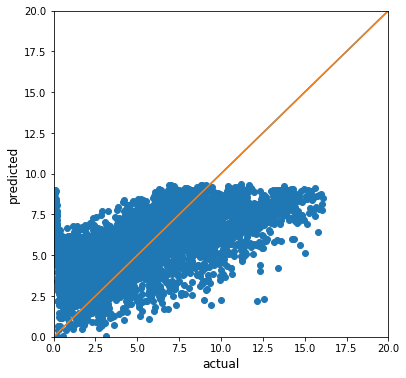

In [11]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train.values.flatten(), y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [12]:
score = mean_absolute_error(y_train.values.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 2.314


In [14]:
submission = pd.read_csv('../LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')

In [15]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)


In [17]:
for seg_id in X_test.index:
    seg = pd.read_csv('../LANL-Earthquake-Prediction/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()

FileNotFoundError: File b'../LANL-Earthquake-Prediction/test/seg_00030f.csv' does not exist

In [ ]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = svm.predict(X_test_scaled)
submission.to_csv('submission.csv')

